# Sentiment Analysis:
### A. Using pre-trained Vader, nltk.
### B. with Logistic Regression Model.

#### Dataset link:https://www.kaggle.com/datasets/d4rklucif3r/restaurant-reviews

In [1]:
#!pip install nltk
#!pip install streamlit
!pip install schedule

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from __future__ import unicode_literals
import string
import re
import csv

#nltk.download()
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.util import bigrams
from nltk.util import trigrams
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,recall_score,precision_score,classification_report,roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans

from wordcloud import WordCloud, STOPWORDS
import pickle
import schedule
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df=pd.read_csv('Restaurant_Reviews.csv', encoding='utf-8')
#Change type from into str
df = df.applymap(str)
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### The Label's column "Liked" only divided into 2 sentiment categories: 1 is positive, 0 is negative

In [4]:
#df['Liked'].dtype
df1= df.replace({'Liked': {'1': 'positive','0': 'negative'}})
df1.head()

,Review,Liked
0,Wow... Loved this place.,positive
1,Crust is not good.,negative
2,Not tasty and the texture was just nasty.,negative
3,Stopped by during the late May bank holiday of...,positive
4,The selection on the menu was great and so wer...,positive


## Cleaning Dataset

In [5]:
#df1.isnull().sum()
df1 = df1.dropna()
df1.isnull().sum()

Review    0
Liked     0
dtype: int64

### Cleaning with Regex
Preprocessing, Cleaning with regex
Make the text lowercase, remove line breaks, punctuation, usernames, url, extra spaces, etc

In [6]:
def cleaning(Review_data):   
    Review_data = str(Review_data).lower()
    Review_data = re.sub(r'#[A-Za-z0–9]+', '', Review_data) #remove hashtags
    Review_data=re.sub(r'@[A-Za-z0–9]+', '',Review_data) #remove usernames    
    Review_data=re.sub(r'@\w+', ' ', Review_data) #remove usernames
    Review_data= re.sub(r'\b\w{1}\b', '', Review_data) #remove stopwords   
    Review_data = re.sub(r'&(?![A-Za-z]+[0-9]*;|#[0-9]+;|#x[0-9a-fA-F]+;)', '', Review_data)
    Review_data = re.sub(r'&amp', '', Review_data) 
    Review_data = re.sub('\n', '', Review_data) #Remove line breaks.
    Review_data = re.sub('[%s]' % re.escape(string.punctuation), '', Review_data) #remove punctuation
    Review_data = re.sub('\[.*?\]', '', Review_data)
    Review_data=re.sub(r'http\S+', ' ', Review_data) #remove all Url
    Review_data = re.sub(r'https?:\/\/.*[\r\n]*', '', Review_data) #remove website
    Review_data = re.sub('https?://\S+|www\.\S+', '', Review_data)  #remove all websites 
    Review_data = re.sub(r' +', ' ', Review_data) #remove extra space
    Review_data = re.sub('<.*?>+', '', Review_data)    
    Review_data = re.sub('\w*\d\w*', '', Review_data)
    Review_data = re.sub(r'^RT[\s]+', '', Review_data)    
    Review_data = re.sub(r'[^a-z A-Z]', ' ',Review_data) #Remove all not characters
    return Review_data

df1['Clean_Reviews'] = df1['Review'].apply(cleaning)
df1.head(10)

,Review,Liked,Clean_Reviews
0,Wow... Loved this place.,positive,wow loved this place
1,Crust is not good.,negative,crust is not good
2,Not tasty and the texture was just nasty.,negative,not tasty and the texture was just nasty
3,Stopped by during the late May bank holiday of...,positive,stopped by during the late may bank holiday of...
4,The selection on the menu was great and so wer...,positive,the selection on the menu was great and so wer...
5,Now I am getting angry and I want my damn pho.,negative,now am getting angry and want my damn pho
6,Honeslty it didn't taste THAT fresh.),negative,honeslty it didn taste that fresh
7,The potatoes were like rubber and you could te...,negative,the potatoes were like rubber and you could te...
8,The fries were great too.,positive,the fries were great too
9,A great touch.,positive,great touch


### Lemitization with nltk

In [7]:
##lemmatization to bring the words in their root form  
lem = WordNetLemmatizer()
df1['Clean_Reviews'] = df1['Clean_Reviews'].apply(
    lambda x: " ".join([lem.lemmatize(word) for word in x.split()]))

df1.head(10)

,Review,Liked,Clean_Reviews
0,Wow... Loved this place.,positive,wow loved this place
1,Crust is not good.,negative,crust is not good
2,Not tasty and the texture was just nasty.,negative,not tasty and the texture wa just nasty
3,Stopped by during the late May bank holiday of...,positive,stopped by during the late may bank holiday of...
4,The selection on the menu was great and so wer...,positive,the selection on the menu wa great and so were...
5,Now I am getting angry and I want my damn pho.,negative,now am getting angry and want my damn pho
6,Honeslty it didn't taste THAT fresh.),negative,honeslty it didn taste that fresh
7,The potatoes were like rubber and you could te...,negative,the potato were like rubber and you could tell...
8,The fries were great too.,positive,the fry were great too
9,A great touch.,positive,great touch


### Stemming with nltk

In [8]:
stm = PorterStemmer()
df1['Clean_Reviews'] = df1['Clean_Reviews'].apply(
    lambda x: " ".join([stm.stem(word) for word in x.split()]))
df1.head(10)

,Review,Liked,Clean_Reviews
0,Wow... Loved this place.,positive,wow love thi place
1,Crust is not good.,negative,crust is not good
2,Not tasty and the texture was just nasty.,negative,not tasti and the textur wa just nasti
3,Stopped by during the late May bank holiday of...,positive,stop by dure the late may bank holiday off ric...
4,The selection on the menu was great and so wer...,positive,the select on the menu wa great and so were th...
5,Now I am getting angry and I want my damn pho.,negative,now am get angri and want my damn pho
6,Honeslty it didn't taste THAT fresh.),negative,honeslti it didn tast that fresh
7,The potatoes were like rubber and you could te...,negative,the potato were like rubber and you could tell...
8,The fries were great too.,positive,the fri were great too
9,A great touch.,positive,great touch


### Remove stopwords with nltk

In [9]:
stopwords = nltk.corpus.stopwords.words('english') 
df1['Cleaned_Reviews'] = df1['Clean_Reviews'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stopwords))

df1.head()

,Review,Liked,Clean_Reviews,Cleaned_Reviews
0,Wow... Loved this place.,positive,wow love thi place,wow love thi place
1,Crust is not good.,negative,crust is not good,crust good
2,Not tasty and the texture was just nasty.,negative,not tasti and the textur wa just nasti,tasti textur wa nasti
3,Stopped by during the late May bank holiday of...,positive,stop by dure the late may bank holiday off ric...,stop dure late may bank holiday rick steve rec...
4,The selection on the menu was great and so wer...,positive,the select on the menu wa great and so were th...,select menu wa great price


### For Sentiment analysis we use "Clean_Reviews" columns, since it's not remove negative words like "is not".
### For Topic extracton we use "Cleaned_Reviews" columns.

# A. with pre-trained Vader, nltk.

In [10]:
sid = SentimentIntensityAnalyzer()

In [11]:
sid.polarity_scores(df1.loc[0]['Cleaned_Reviews'])

{'neg': 0.0, 'neu': 0.2, 'pos': 0.8, 'compound': 0.8402}

In [12]:
df1['Score'] = df1['Clean_Reviews'].apply(lambda Cleaned_Reviews: sid.polarity_scores(Cleaned_Reviews))
df1['compound']  = df1['Score'].apply(lambda score_dict: score_dict['compound'])
df1['Sentiment'] = df1['compound'].apply(lambda c: 'positive' if c > 0 else ('negative' if c < 0 else 'negative'))
df1[['Review','Liked','Clean_Reviews','Score','compound','Sentiment']].head()

,Review,Liked,Clean_Reviews,Score,compound,Sentiment
0,Wow... Loved this place.,positive,wow love thi place,"{'neg': 0.0, 'neu': 0.2, 'pos': 0.8, 'compound...",0.8402,positive
1,Crust is not good.,negative,crust is not good,"{'neg': 0.445, 'neu': 0.555, 'pos': 0.0, 'comp...",-0.3412,negative
2,Not tasty and the texture was just nasty.,negative,not tasti and the textur wa just nasti,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,negative
3,Stopped by during the late May bank holiday of...,positive,stop by dure the late may bank holiday off ric...,"{'neg': 0.097, 'neu': 0.487, 'pos': 0.416, 'co...",0.8020,positive
4,The selection on the menu was great and so wer...,positive,the select on the menu wa great and so were th...,"{'neg': 0.0, 'neu': 0.728, 'pos': 0.272, 'comp...",0.6249,positive


### Divide into 2 sentiment categories: positive and negative

In [13]:
df1['Review'][3] 

'Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.'

In [14]:
df1['Review'][4] 

'The selection on the menu was great and so were the prices.'

# Count Accuracy
### Comparing label "Liked" column vs "sentiment" column

In [15]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [16]:
print(classification_report(df1['Liked'],df1['Sentiment']))

              precision    recall  f1-score   support

    negative       0.68      0.76      0.72       500
    positive       0.73      0.65      0.69       500

    accuracy                           0.70      1000
   macro avg       0.71      0.70      0.70      1000
weighted avg       0.71      0.70      0.70      1000



In [17]:
print(confusion_matrix(df1['Liked'],df1['Sentiment']))

[[380 120]
 [177 323]]


### Accuracy is quite good

In [18]:
accuracy_score(df1['Liked'],df1['Sentiment'])

0.703

# Divide into 3 categories: Positive, Negative, Neutral

In [19]:
df1['Sentiment'] = df1['compound'].apply(lambda c: 'positive' if c > 0 else ('negative' if c < 0 else 'neutral'))
df1[['Review','Liked','Clean_Reviews','Score','compound','Sentiment']].head()

,Review,Liked,Clean_Reviews,Score,compound,Sentiment
0,Wow... Loved this place.,positive,wow love thi place,"{'neg': 0.0, 'neu': 0.2, 'pos': 0.8, 'compound...",0.8402,positive
1,Crust is not good.,negative,crust is not good,"{'neg': 0.445, 'neu': 0.555, 'pos': 0.0, 'comp...",-0.3412,negative
2,Not tasty and the texture was just nasty.,negative,not tasti and the textur wa just nasti,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
3,Stopped by during the late May bank holiday of...,positive,stop by dure the late may bank holiday off ric...,"{'neg': 0.097, 'neu': 0.487, 'pos': 0.416, 'co...",0.8020,positive
4,The selection on the menu was great and so wer...,positive,the select on the menu wa great and so were th...,"{'neg': 0.0, 'neu': 0.728, 'pos': 0.272, 'comp...",0.6249,positive


# Count each sentiment

In [20]:
sentiment_count = df1['Sentiment'].value_counts()
sentiment_count

positive    443
neutral     352
negative    205
Name: Sentiment, dtype: int64

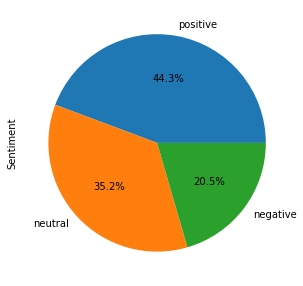

In [21]:
plot_users=sentiment_count.plot.pie(autopct='%1.1f%%', figsize=(5, 5))
plt.rc('axes', unicode_minus=False)
plt.savefig("sentiment_count_chart.jpeg",transparent=False, bbox_inches='tight',pad_inches=0.1)

In [22]:
df1.iloc[:, 0:2].head()

,Review,Liked
0,Wow... Loved this place.,positive
1,Crust is not good.,negative
2,Not tasty and the texture was just nasty.,negative
3,Stopped by during the late May bank holiday of...,positive
4,The selection on the menu was great and so wer...,positive


In [23]:
df1.head(3)

,Review,Liked,Clean_Reviews,Cleaned_Reviews,Score,compound,Sentiment
0,Wow... Loved this place.,positive,wow love thi place,wow love thi place,"{'neg': 0.0, 'neu': 0.2, 'pos': 0.8, 'compound...",0.8402,positive
1,Crust is not good.,negative,crust is not good,crust good,"{'neg': 0.445, 'neu': 0.555, 'pos': 0.0, 'comp...",-0.3412,negative
2,Not tasty and the texture was just nasty.,negative,not tasti and the textur wa just nasti,tasti textur wa nasti,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral


### Replace value become "neutral"  in "Liked" column, if compound == 0

In [24]:
df1['Liked'].mask(df1['compound'] ==0 ,'neutral', inplace=True)

In [25]:
df1.head(3)

,Review,Liked,Clean_Reviews,Cleaned_Reviews,Score,compound,Sentiment
0,Wow... Loved this place.,positive,wow love thi place,wow love thi place,"{'neg': 0.0, 'neu': 0.2, 'pos': 0.8, 'compound...",0.8402,positive
1,Crust is not good.,negative,crust is not good,crust good,"{'neg': 0.445, 'neu': 0.555, 'pos': 0.0, 'comp...",-0.3412,negative
2,Not tasty and the texture was just nasty.,neutral,not tasti and the textur wa just nasti,tasti textur wa nasti,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral


## Write into new .csv dataset which have 3 sentiments
### 1 == positive, 0 == neutral, -1 == negative

In [26]:
#df1[['Review','Sentiment']].to_csv('Restaurant_Reviews_pos_neu_neg.csv', encoding='utf-8')
df2 = df1.drop(columns=['Clean_Reviews','Cleaned_Reviews','Score','compound','Sentiment']).replace(
    {'Liked': {'positive':'1','neutral': '0','negative': '-1'}}).to_csv(
    'Restaurant_Reviews_pos_neu_neg.csv', encoding='utf-8',  index=False)
print("done saving")

done saving


In [27]:
df2=pd.read_csv('Restaurant_Reviews_pos_neu_neg.csv', encoding='utf-8',index_col=0)
#Change type from into strindex_col=0
df2 = df2.applymap(str)
df2.head()

,Liked
Review,
Wow... Loved this place.,1
Crust is not good.,-1
Not tasty and the texture was just nasty.,0
Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1
The selection on the menu was great and so were the prices.,1


In [28]:
df2= df2.replace({'Liked': {'1': 'positive','0': 'neutral','-1': 'negative'}})
df2.head()

,Liked
Review,
Wow... Loved this place.,positive
Crust is not good.,negative
Not tasty and the texture was just nasty.,neutral
Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,positive
The selection on the menu was great and so were the prices.,positive


## Vectorize cleaned texts with CountVectorizer with ngrame_range
ngram_range of (1, 1) means only unigrams. (1, 2) means unigrams and bigrams. (1, 3) means unigrams, bigrams, and trigrams. (2, 2) means only bigrams.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [29]:
countv = CountVectorizer(min_df=1,max_df=0.95,ngram_range=(1,3),stop_words='english')
countv_text = countv.fit_transform(df1['Cleaned_Reviews'])
countv_text

<1000x8751 sparse matrix of type '<class 'numpy.int64'>'
	with 13220 stored elements in Compressed Sparse Row format>

In [30]:
countv_text.shape

(1000, 8751)

## Vectorize cleaned texts with Tf-IDF with ngram_range

In [31]:
tfidf = TfidfVectorizer(min_df=1 ,max_df=0.95, ngram_range=(1,3),stop_words='english', lowercase=True, smooth_idf=True)
tfidf_text = tfidf.fit_transform(df1['Clean_Reviews'])
tfidf_text

<1000x9063 sparse matrix of type '<class 'numpy.float64'>'
	with 13710 stored elements in Compressed Sparse Row format>

## Topic extraction with LDA (Latent Dirichlet Allocation) and Countvectorizer

In [32]:
LDA_countv = LatentDirichletAllocation(n_components=5,random_state=42)
LDA_countv.fit(countv_text)

LatentDirichletAllocation(n_components=5, random_state=42)

In [33]:
#len(LDA_countv.components_[0])
LDA_countv.components_

array([[1.20010796, 0.20000212, 0.20000212, ..., 1.19999047, 0.20000383,
        1.19999489],
       [1.19988017, 1.19999127, 1.19999127, ..., 0.20000189, 0.200003  ,
        0.20000105],
       [0.20000393, 0.20000221, 0.20000221, ..., 0.2000024 , 0.20000383,
        0.20000133],
       [0.20000399, 0.20000221, 0.20000221, ..., 0.20000248, 0.20000394,
        0.20000136],
       [0.20000395, 0.20000219, 0.20000219, ..., 0.20000275, 1.19998541,
        0.20000138]])

In [34]:
eachtopic = LDA_countv.components_[0]
eachtopic.argsort()

array([3388,  426, 4334, ..., 6415, 6357, 7955], dtype=int64)

In [35]:
#eachtopic[183]
# Top 5 words for this topic:
eachtopic.argsort()[-5:]

array([2855, 2513, 6415, 6357, 7955], dtype=int64)

In [36]:
word_top = eachtopic.argsort()[-5:]
for index in word_top:
    print(countv.get_feature_names()[index])

good
food
servic wa
servic
wa


In [37]:
for index,topic in enumerate(LDA_countv.components_):
    print(f'Most prevalent topic #{index}'+ ': ')
    print([countv.get_feature_names()[i] for i in topic.argsort()[-10:]])

Most prevalent topic #0: 
['staff', 'order', 'food wa', 'slow', 'time', 'good', 'food', 'servic wa', 'servic', 'wa']
Most prevalent topic #1: 
['great', 'servic', 'like', 'veri', 'good', 'food', 'thi place', 'place', 'thi', 'wa']
Most prevalent topic #2: 
['time', 'eat', 'thi place', 'veri', 'wait', 'thi', 'place', 'great', 'wa', 'food']
Most prevalent topic #3: 
['like', 'love', 'great', 'time', 'place', 'food', 'veri', 'servic', 'good', 'wa']
Most prevalent topic #4: 
['star', 'food', 'thi place', 'servic', 'realli', 'restaur', 'great', 'place', 'thi', 'wa']


In [38]:
topic_lda_cv = LDA_countv.transform(countv_text)
topic_lda_cv[0].argmax()
topic_lda_cv.argmax(axis=1)
df1['Topic_lda_cv'] = topic_lda_cv.argmax(axis=1)
df1[['Review','Sentiment','Cleaned_Reviews','Topic_lda_cv']].head()

,Review,Sentiment,Cleaned_Reviews,Topic_lda_cv
0,Wow... Loved this place.,positive,wow love thi place,1
1,Crust is not good.,negative,crust good,0
2,Not tasty and the texture was just nasty.,neutral,tasti textur wa nasti,2
3,Stopped by during the late May bank holiday of...,positive,stop dure late may bank holiday rick steve rec...,0
4,The selection on the menu was great and so wer...,positive,select menu wa great price,4


## Topic extraction with LDA (Latent Dirichlet Allocation) with Tf-IDF

In [39]:
LDA_tfidf = LatentDirichletAllocation(n_components=5,random_state=42)
LDA_tfidf.fit(tfidf_text)

LatentDirichletAllocation(n_components=5, random_state=42)

In [40]:
LDA_tfidf.components_

array([[0.4318861 , 0.44560617, 0.44560617, ..., 0.20001676, 0.20002758,
        0.20001433],
       [0.41879973, 0.2000147 , 0.2000147 , ..., 0.20001656, 0.2000276 ,
        0.40226689],
       [0.20003228, 0.20001608, 0.20001608, ..., 0.20001661, 0.20002743,
        0.20001433],
       [0.20003033, 0.20001467, 0.20001467, ..., 0.2000155 , 0.20002585,
        0.20001326],
       [0.20003117, 0.20001473, 0.20001473, ..., 0.46984069, 0.49742403,
        0.20001426]])

In [41]:
eachtopics = LDA_tfidf.components_[0]
eachtopics.argsort()

array([3715, 7164, 5639, ..., 2986, 3141, 8225], dtype=int64)

In [42]:
#eachtopics[183]
# Top 5 words for this topic:
eachtopics.argsort()[-5:]

array([8100, 7443, 2986, 3141, 8225], dtype=int64)

In [43]:
for index,topic in enumerate(LDA_tfidf.components_):
    print(f'Most prevalent topic #{index}'+ ': ')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-10:]]) 

Most prevalent topic #0: 
['return', 'excel', 'thumb', 'servic', 'food', 'veri', 'thi', 'good', 'great', 'wa']
Most prevalent topic #1: 
['good', 'recommend', 'servic', 'food', 'veri', 'thi place', 'thi', 'place', 'won', 'wa']
Most prevalent topic #2: 
['pizza', 'good', 'veri', 'think', 'time', 'don', 'place', 'definit', 'food', 'wa']
Most prevalent topic #3: 
['time', 'servic', 'wait', 'great', 'food', 'love', 'thi place', 'place', 'thi', 'wa']
Most prevalent topic #4: 
['like', 'servic wa', 'thi', 'come', 'eat', 'terribl', 'food', 'good', 'servic', 'wa']


In [44]:
topic_lda_tfidf = LDA_tfidf.transform(tfidf_text)
topic_lda_tfidf.shape
topic_lda_tfidf[0].round(2)
topic_lda_tfidf[0].argmax()
topic_lda_tfidf.argmax(axis=1)

array([3, 2, 3, 0, 4, 1, 4, 4, 0, 0, 4, 0, 4, 3, 3, 0, 1, 3, 3, 1, 0, 1,
       2, 2, 3, 4, 1, 2, 4, 2, 4, 4, 3, 3, 1, 4, 2, 1, 4, 0, 1, 3, 3, 3,
       1, 4, 1, 1, 4, 2, 4, 2, 3, 0, 1, 3, 0, 1, 1, 1, 1, 3, 3, 2, 1, 2,
       1, 3, 3, 3, 1, 4, 4, 4, 1, 2, 3, 1, 2, 1, 4, 4, 1, 1, 3, 0, 2, 3,
       4, 4, 3, 3, 3, 2, 2, 0, 0, 3, 4, 0, 3, 3, 2, 0, 0, 1, 3, 3, 4, 4,
       1, 0, 1, 1, 4, 1, 1, 1, 4, 1, 2, 2, 4, 3, 3, 4, 3, 4, 2, 2, 1, 4,
       4, 2, 2, 4, 4, 2, 2, 4, 2, 2, 1, 2, 1, 2, 1, 4, 0, 2, 2, 0, 0, 1,
       1, 1, 4, 3, 3, 2, 2, 1, 0, 0, 0, 3, 0, 0, 2, 4, 1, 4, 4, 1, 4, 2,
       3, 4, 3, 4, 0, 2, 1, 0, 0, 0, 0, 1, 1, 2, 4, 2, 4, 3, 3, 1, 0, 1,
       0, 3, 2, 3, 1, 3, 4, 3, 3, 3, 2, 4, 4, 1, 2, 1, 2, 0, 1, 4, 4, 3,
       0, 4, 1, 3, 0, 4, 3, 2, 3, 1, 3, 2, 3, 4, 3, 1, 4, 3, 0, 3, 2, 2,
       3, 3, 1, 3, 1, 0, 2, 3, 2, 2, 0, 1, 3, 4, 1, 4, 2, 0, 4, 0, 1, 4,
       3, 1, 4, 3, 4, 3, 4, 4, 2, 0, 0, 0, 0, 2, 2, 2, 1, 4, 3, 3, 2, 2,
       4, 4, 1, 4, 0, 2, 3, 2, 4, 3, 4, 0, 3, 1, 3,

In [45]:
df1['Topic_lda_tfidf'] = topic_lda_tfidf.argmax(axis=1)
df1[['Review','Sentiment','Cleaned_Reviews','Topic_lda_tfidf']].head()

,Review,Sentiment,Cleaned_Reviews,Topic_lda_tfidf
0,Wow... Loved this place.,positive,wow love thi place,3
1,Crust is not good.,negative,crust good,2
2,Not tasty and the texture was just nasty.,neutral,tasti textur wa nasti,3
3,Stopped by during the late May bank holiday of...,positive,stop dure late may bank holiday rick steve rec...,0
4,The selection on the menu was great and so wer...,positive,select menu wa great price,4


### Topic extraction with NMF (Non-Negative Matric Factorization) with Countvectorizer

In [46]:
nmf_model_cv = NMF(n_components=5, random_state=42) 
nmf_model_cv.fit(countv_text)

NMF(n_components=5, random_state=42)

In [47]:
for index,topic in enumerate(nmf_model_cv.components_):
    print(f'Most prevalent topic #{index}'+ ': ')
    print([countv.get_feature_names()[i] for i in topic.argsort()[-10:]]) 

Most prevalent topic #0: 
['like', 'flavor', 'burger', 'disappoint', 'onli', 'time', 'wa veri', 'servic wa', 'food wa', 'wa']
Most prevalent topic #1: 
['recommend thi place', 'recommend thi', 'love', 'want', 'restaur', 'recommend', 'like', 'thi place', 'place', 'thi']
Most prevalent topic #2: 
['like', 'good', 'minut', 'delici', 'good food', 'bad food', 'bad', 'wait', 'food wa', 'food']
Most prevalent topic #3: 
['realli good', 'select', 'good food', 'price', 'realli', 'wa good', 'veri good', 'wa veri', 'veri', 'good']
Most prevalent topic #4: 
['custom', 'server', 'slow', 'menu', 'great food', 'great servic', 'friendli', 'servic wa', 'great', 'servic']


In [48]:
topic_nmf_cv = nmf_model_cv.transform(countv_text)
topic_nmf_cv.argmax(axis=1)
df1['Topic_nmf_cv'] = topic_nmf_cv.argmax(axis=1)
df1[['Review','Sentiment','Cleaned_Reviews','Topic_nmf_cv']].head()

,Review,Sentiment,Cleaned_Reviews,Topic_nmf_cv
0,Wow... Loved this place.,positive,wow love thi place,1
1,Crust is not good.,negative,crust good,3
2,Not tasty and the texture was just nasty.,neutral,tasti textur wa nasti,0
3,Stopped by during the late May bank holiday of...,positive,stop dure late may bank holiday rick steve rec...,1
4,The selection on the menu was great and so wer...,positive,select menu wa great price,4


### Topic extraction with NMF (Non-Negative Matric Factorization) with Tf-IDF

In [49]:
nmf_model_tfidf= NMF(n_components = 5, random_state=42)
nmf_model_tfidf.fit(tfidf_text)

NMF(n_components=5, random_state=42)

In [50]:
for index,topic in enumerate(nmf_model_tfidf.components_):
    print(f'Most prevalent topic #{index}'+ ': ')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-10:]])  

Most prevalent topic #0: 
['food wa terribl', 'wa delici', 'delici', 'wa terribl', 'terribl', 'food', 'food wa', 'servic wa', 'servic', 'wa']
Most prevalent topic #1: 
['place amaz', 'love thi', 'love thi place', 'recommend thi place', 'recommend thi', 'recommend', 'love', 'thi place', 'thi', 'place']
Most prevalent topic #2: 
['soon', 'anytim soon', 'anytim', 'probabl won', 'won return', 'return', 'probabl', 'won disappoint', 'disappoint', 'won']
Most prevalent topic #3: 
['dinner', 'fri great', 'food great', 'great place', 'eat', 'servic', 'great servic', 'food', 'great food', 'great']
Most prevalent topic #4: 
['good price', 'good food', 'price', 'food good', 'wa veri', 'food', 'veri good', 'wa good', 'veri', 'good']


In [51]:
topic_nmf_tfidf = nmf_model_tfidf.transform(tfidf_text)
topic_nmf_tfidf.argmax(axis=1)
df1['Topics_nmf_tfidf'] = topic_nmf_tfidf.argmax(axis=1)
df1[['Review','Sentiment','Cleaned_Reviews','Topics_nmf_tfidf']].head()

,Review,Sentiment,Cleaned_Reviews,Topics_nmf_tfidf
0,Wow... Loved this place.,positive,wow love thi place,1
1,Crust is not good.,negative,crust good,4
2,Not tasty and the texture was just nasty.,neutral,tasti textur wa nasti,0
3,Stopped by during the late May bank holiday of...,positive,stop dure late may bank holiday rick steve rec...,1
4,The selection on the menu was great and so wer...,positive,select menu wa great price,3


In [52]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [55]:
#Function to Create Wordcloud

def create_wordcloud(text):
    mask = np.array(Image.open("cloud.png"))
    stopwords = set(STOPWORDS)    
    wcl = WordCloud(background_color="white", max_words=500, mask = mask, repeat=True ,stopwords=stopwords)
    wcl.generate(str(text))
    wcl.to_file("wc.png")
    path="wc.png"
    display(Image.open(path))

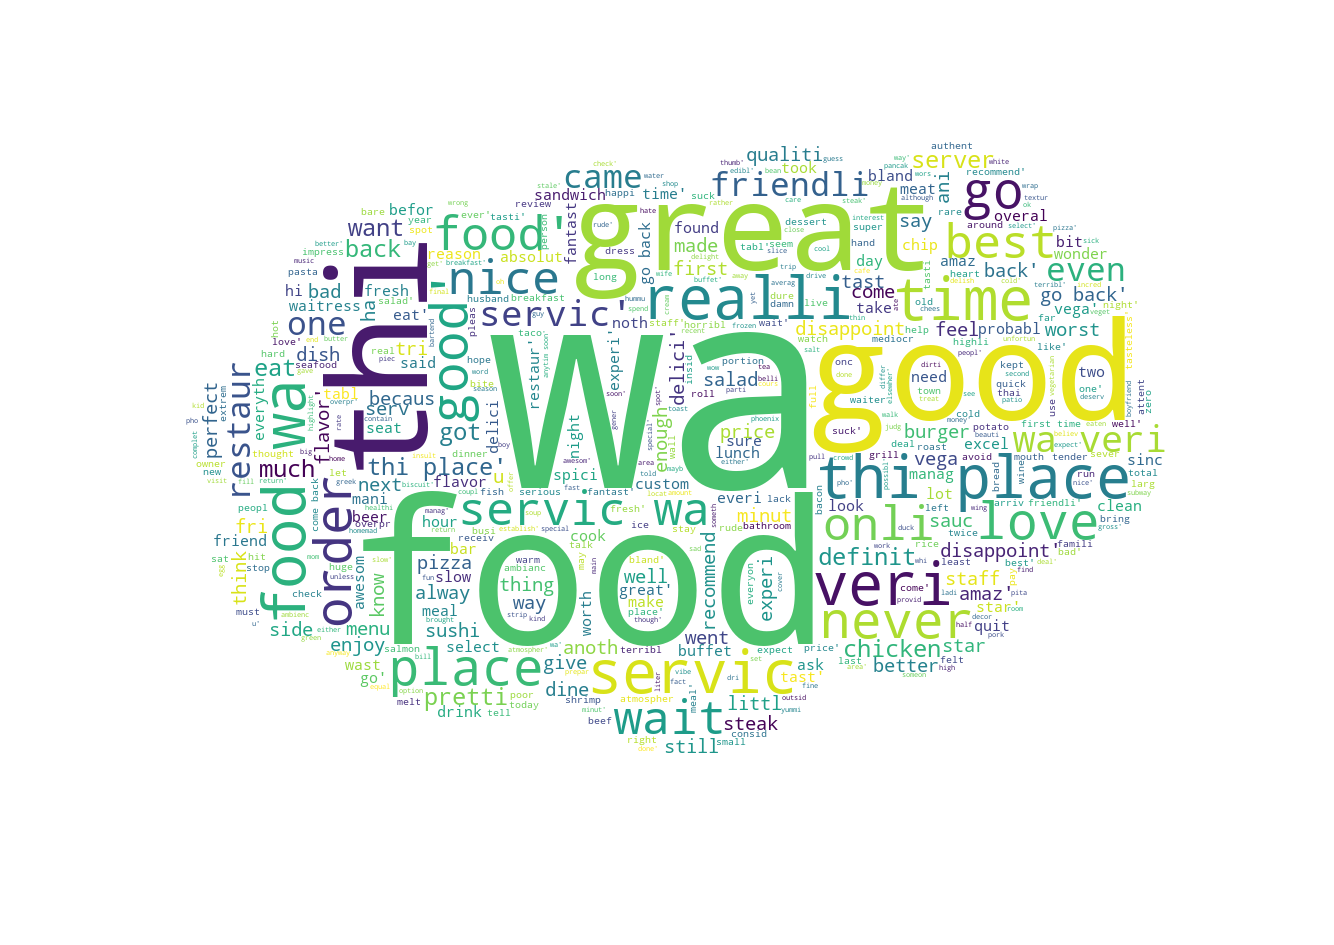

In [56]:
create_wordcloud(df1["Cleaned_Reviews"].values)

# B. with Logistic Regression Model.

## Preprocessing and Cleaning with function

In [57]:
def preprocess(preprocessedtext):   
    
    processedText = []
    for Review_data in preprocessedtext:
        Review_data = str(Review_data).lower()
        Review_data = re.sub(r'#[A-Za-z0–9]+', '', Review_data) #remove hashtags
        Review_data=re.sub(r'@[A-Za-z0–9]+', '',Review_data) #remove usernames    
        Review_data=re.sub(r'@\w+', ' ', Review_data) #remove usernames
        Review_data= re.sub(r'\b\w{1}\b', '', Review_data) #remove stopwords   
        Review_data = re.sub(r'&(?![A-Za-z]+[0-9]*;|#[0-9]+;|#x[0-9a-fA-F]+;)', '', Review_data)
        Review_data = re.sub(r'&amp', '', Review_data) 
        Review_data = re.sub('\n', '', Review_data) #Remove line breaks.
        Review_data = re.sub('[%s]' % re.escape(string.punctuation), '', Review_data) #remove punctuation
        Review_data = re.sub('\[.*?\]', '', Review_data)
        Review_data=re.sub(r'http\S+', ' ', Review_data) #remove all Url
        Review_data = re.sub(r'https?:\/\/.*[\r\n]*', '', Review_data) #remove website
        Review_data = re.sub('https?://\S+|www\.\S+', '', Review_data)  #remove all websites 
        Review_data = re.sub(r' +', ' ', Review_data) #remove extra space
        Review_data = re.sub('<.*?>+', '', Review_data)    
        Review_data = re.sub('\w*\d\w*', '', Review_data)
        Review_data = re.sub(r'^RT[\s]+', '', Review_data)    
        Review_data = re.sub(r'[^a-z A-Z]', ' ',Review_data) #Remove all not characters
        
        processedText.append(Review_data)
        
    return processedText

def get_jvnr(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    if tag.startswith("V"):
        return wordnet.VERB
    if tag.startswith("N"):
        return wordnet.NOUN
    if tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def stemming_process(preprocessedtext):
    # Create stemming
    stm = PorterStemmer()
   
    finalprocessedtext = []
    for word in preprocessedtext:
        text_pos = pos_tag(word_tokenize(word))
        words = [x[0] for x in text_pos]
        pos = [x[1] for x in text_pos]
        word_stm = " ".join([stm.stem(a,get_jvnr(b)) for a,b in zip(words,pos)])
        finalprocessedtext.append(word_stm)
    return finalprocessedtext

def lemmatize_process(preprocessedtext):
    # Create lemmatizer
    lemma = WordNetLemmatizer()
   
    finalprocessedtext = []
    for word in preprocessedtext:
        text_pos = pos_tag(word_tokenize(word))
        words = [x[0] for x in text_pos]
        pos = [x[1] for x in text_pos]
        word_stm = " ".join([lem.lemmatize(a,get_jvnr(b)) for a,b in zip(words,pos)])
        finalprocessedtext.append(word_stm)
    return finalprocessedtext

# Split the Data become train data and test data

In [58]:
# Splitting dataset into train and test, test size of 3%
X_train, X_test, y_train, y_test = train_test_split(df1.Clean_Reviews, df1.Liked, test_size = 0.03, random_state = 0)
print('Done Data Split')

Done Data Split


In [59]:
X_train = tfidf.transform(X_train)
X_test  = tfidf.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [60]:
df1[['Review','Clean_Reviews','Liked']].head(10)

,Review,Clean_Reviews,Liked
0,Wow... Loved this place.,wow love thi place,positive
1,Crust is not good.,crust is not good,negative
2,Not tasty and the texture was just nasty.,not tasti and the textur wa just nasti,neutral
3,Stopped by during the late May bank holiday of...,stop by dure the late may bank holiday off ric...,positive
4,The selection on the menu was great and so wer...,the select on the menu wa great and so were th...,positive
5,Now I am getting angry and I want my damn pho.,now am get angri and want my damn pho,negative
6,Honeslty it didn't taste THAT fresh.),honeslti it didn tast that fresh,negative
7,The potatoes were like rubber and you could te...,the potato were like rubber and you could tell...,negative
8,The fries were great too.,the fri were great too,positive
9,A great touch.,great touch,positive


## Develop Models : LinearSVC, Bernoulli NB, Logistic Regression

In [61]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))   
    
    #return y_pred

### BernoulliNB

In [62]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        10
     neutral       0.38      1.00      0.55         9
    positive       1.00      0.55      0.71        11

    accuracy                           0.50        30
   macro avg       0.46      0.52      0.42        30
weighted avg       0.48      0.50      0.42        30



### LinearSVC

In [63]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

    negative       0.88      0.70      0.78        10
     neutral       0.73      0.89      0.80         9
    positive       0.82      0.82      0.82        11

    accuracy                           0.80        30
   macro avg       0.81      0.80      0.80        30
weighted avg       0.81      0.80      0.80        30



### Logistic Regression

In [64]:
LRmodel = LogisticRegression(C = 1, max_iter = 1000, n_jobs=-1)
LogReg = LRmodel.fit(X_train, y_train)
y_test_pred = model_Evaluate(LRmodel)

              precision    recall  f1-score   support

    negative       0.86      0.60      0.71        10
     neutral       0.73      0.89      0.80         9
    positive       0.83      0.91      0.87        11

    accuracy                           0.80        30
   macro avg       0.81      0.80      0.79        30
weighted avg       0.81      0.80      0.79        30



##### Logistic Regression accuracy is around 80% accuracy

## Saving the Model
#### Using PICKLE to save tfidf and Logistic Regression Model for later use.

In [65]:
def train_models():
    file = open('vectorizer.pickle','wb')
    pickle.dump(tfidf, file)
    file.close()

    file = open('sentimentanalysis_LR.pickle','wb')
    pickle.dump(LRmodel, file)
    file.close()
    
    print("Models saved")

In [66]:
train_models()

Models saved


## Using the Model

In [67]:
def load_models():  
       
    # Load the vectorizer.
    file = open('vectorizer.pickle', 'rb')
    vectorizer = pickle.load(file)
    file.close()
    
    # Load the LR Model.
    file = open('sentimentanalysis_LR.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectorizer, LRmodel

In [68]:
def predict_a(vectorizer, model, text):
    finaldata_a = []

    textdata_a = vectorizer.transform((lemmatize_process(stemming_process(preprocess(text)))))
    sentiment_a = model.predict(textdata_a)
    sentimentp_a = model.predict_proba(textdata_a)
    
    for index,sentences in enumerate(text):
        if sentiment_a[index] == 0:
            sentimentp_aFinal = sentimentp_a[index][0]
        else:  
            sentimentp_aFinal = sentimentp_a[index][1]
            
        sentimentpFinal_a = "{}%".format(round(sentimentp_aFinal*100,2))
        finaldata_a.append((sentences, sentiment_a[index], sentimentpFinal_a))
           
    return finaldata_a

In [69]:
message_a = ["The purpose of life is to love"]

In [70]:
vectorizer, LRmodel = load_models()
text_a = predict_a(vectorizer, LRmodel, message_a)
text_a

[('The purpose of life is to love', 'positive', '15.27%')]

In [71]:
message = ["The food is good",
       "The juice is too sour",
        "I feel disappointed"
        ]

In [72]:
def predict_message(vectorizer, model, text):
    finaldata = []

    textdata = vectorizer.transform((lemmatize_process(stemming_process(preprocess(text)))))
    sentiment = model.predict(textdata)
    sentimentp = model.predict_proba(textdata)
    
    for index,sentences in enumerate(text):
        if sentiment[index] == -1:
            sentimentpFinal = sentimentp[index][-1]
        elif sentiment[index] == 0:  
            sentimentpFinal = sentimentp[index][0]
        else:  
            sentimentpFinal = sentimentp[index][1]  
            
        sentimentpFinal3 = "{}%".format(round(sentimentpFinal*100,3))
        finaldata.append((sentences, sentiment[index], sentimentpFinal3))
           
    # Convert the list into a Pandas DataFrame.
    dfmessages = pd.DataFrame(finaldata, columns = ['sentences','sentiment', 'Probability(Confidence Level)'])
    dfmessages = dfmessages.replace([0,1,-1], ["negative","neutral","positive"])
    return dfmessages

In [73]:
vectorizer, LRmodel = load_models()
dfmessage = predict_message(vectorizer, LRmodel, message)
dfmessage.head(10)

,sentences,sentiment,Probability(Confidence Level)
0,The food is good,positive,8.882%
1,The juice is too sour,neutral,44.101%
2,I feel disappointed,negative,10.595%


In [74]:
dfmessage_b = dfmessage[['sentences','sentiment']]
dfmessage_b

,sentences,sentiment
0,The food is good,positive
1,The juice is too sour,neutral
2,I feel disappointed,negative


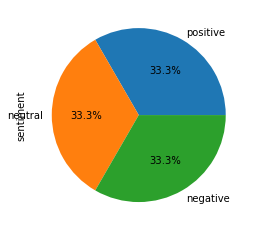

In [75]:
sentiment_counts = dfmessage['sentiment'].value_counts()
plot_users=sentiment_counts.plot.pie(autopct='%1.1f%%', figsize=(4, 4))
plt.rc('axes', unicode_minus=False)
plt.savefig("sentiment_counts_chart.jpeg",transparent=False, bbox_inches='tight',pad_inches=0.1)

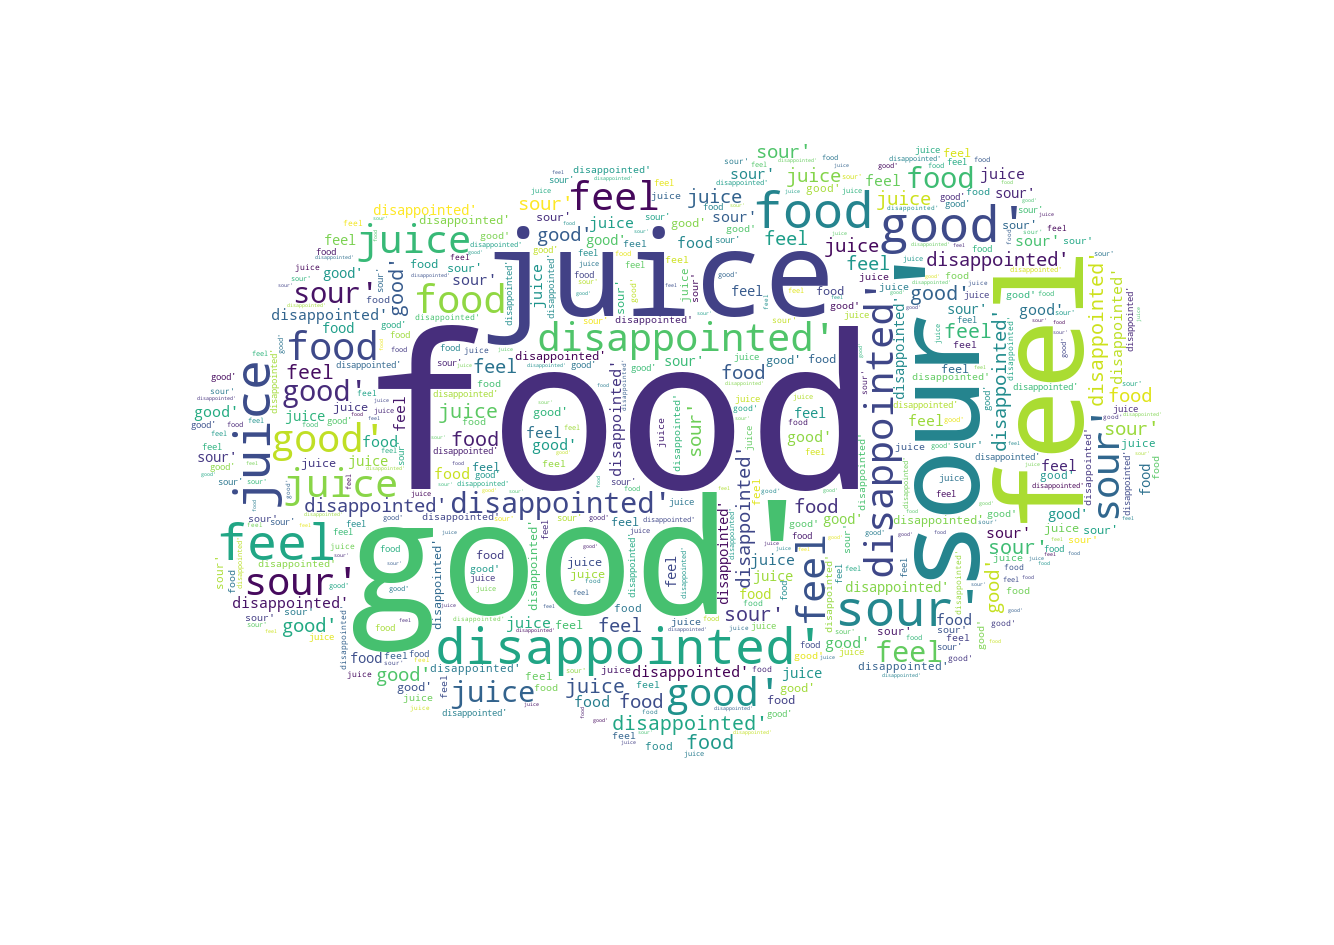

In [76]:
create_wordcloud(message)

# Create App with streamlit
https://streamlit.io/
https://docs.streamlit.io/library/api-reference

In [77]:
%%writefile app.py

import pandas as pd
import numpy as np
import streamlit as st
#import joblib
from PIL import Image
import pickle
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import re
import string
import matplotlib.pyplot as plt
import time


@st.cache(allow_output_mutation=True)

def load(vectorizer_path, model_path):

    # Load the vectorizer.
    file = open(vectorizer_path, 'rb')
    vectorizer = pickle.load(file)
    file.close()
    
    # Load the Logistic Regression Model.
    file = open(model_path, 'rb')
    LRmodel = pickle.load(file)
    file.close()    
    return vectorizer, LRmodel

def predict(vectorizer, model, texts, cols):  
    text = texts.split(";")    
    finaldata = []
    
    textdata = vectorizer.transform((lemmatize_process(stemming_process(preprocess(text)))))
    sentiment = model.predict(textdata)
    sentimentp = model.predict_proba(textdata)
    
    for index,sentences in enumerate(text):
        if sentiment[index] == -1:
            sentimentpFinal = sentimentp[index][-1]
        elif sentiment[index] == 0:  
            sentimentpFinal = sentimentp[index][0]
        else:  
            sentimentpFinal = sentimentp[index][1]  
            
        sentimentpFinal3 = "{}%".format(round(sentimentpFinal*100,3))
        finaldata.append((sentences, sentiment[index], sentimentpFinal3))
           
    # Convert the list into a Pandas DataFrame.
    dfmessages = pd.DataFrame(finaldata, columns = ['sentences','sentiment', 'Probability(Confidence Level)']) 
    
    # append new review and sentiment to existing dataframe
    dfmessages2 = dfmessages[['sentences','sentiment']].replace(["negative","neutral","positive"],[-1,0,1] )
    dfmessages2.to_csv('Restaurant_Reviews_pos_neu_neg.csv', mode='a', index=False, header=False)
    
    dfmessages = dfmessages.replace([-1,0,1], ["negative","neutral","positive"])      
    return dfmessages    

    
def get_jvnr(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    if tag.startswith("V"):
        return wordnet.VERB
    if tag.startswith("N"):
        return wordnet.NOUN
    if tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_process(preprocessedtext):
    # Create lemmatizer
    lem = WordNetLemmatizer()   
    finalprocessedtext = []
    for word in preprocessedtext:
        text_pos = pos_tag(word_tokenize(word))
        words = [x[0] for x in text_pos]
        pos = [x[1] for x in text_pos]
        word_stm = " ".join([lem.lemmatize(a,get_jvnr(b)) for a,b in zip(words,pos)])
        finalprocessedtext.append(word_stm)
    return finalprocessedtext
    
def stemming_process(preprocessedtext):
    # Create stemming
    stm = PorterStemmer()   
    finalprocessedtext = []
    for word in preprocessedtext:
        text_pos = pos_tag(word_tokenize(word))
        words = [x[0] for x in text_pos]
        pos = [x[1] for x in text_pos]
        word_stm = " ".join([stm.stem(a,get_jvnr(b)) for a,b in zip(words,pos)])
        finalprocessedtext.append(word_stm)
    return finalprocessedtext    

def preprocess(preprocessedtext):     
    processedText = []
    for Review_data in preprocessedtext:
        Review_data = str(Review_data).lower()
        Review_data = re.sub(r'#[A-Za-z0–9]+', '', Review_data) #remove hashtags
        Review_data=re.sub(r'@[A-Za-z0–9]+', '',Review_data) #remove usernames    
        Review_data=re.sub(r'@\w+', ' ', Review_data) #remove usernames
        Review_data= re.sub(r'\b\w{1}\b', '', Review_data) #remove stopwords   
        Review_data = re.sub(r'&(?![A-Za-z]+[0-9]*;|#[0-9]+;|#x[0-9a-fA-F]+;)', '', Review_data)
        Review_data = re.sub(r'&amp', '', Review_data) 
        Review_data = re.sub('\n', '', Review_data) #Remove line breaks.
        Review_data = re.sub('[%s]' % re.escape(string.punctuation), '', Review_data) #remove punctuation
        Review_data = re.sub('\[.*?\]', '', Review_data)
        Review_data=re.sub(r'http\S+', ' ', Review_data) #remove all Url
        Review_data = re.sub(r'https?:\/\/.*[\r\n]*', '', Review_data) #remove website
        Review_data = re.sub('https?://\S+|www\.\S+', '', Review_data)  #remove all websites 
        Review_data = re.sub(r' +', ' ', Review_data) #remove extra space
        Review_data = re.sub('<.*?>+', '', Review_data)    
        Review_data = re.sub('\w*\d\w*', '', Review_data)
        Review_data = re.sub(r'^RT[\s]+', '', Review_data)    
        Review_data = re.sub(r'[^a-z A-Z]', ' ',Review_data) #Remove all not characters        
        processedText.append(Review_data)        
    return processedText

#to show  progress bar
def show_progress():
    the_bar = st.progress(0)
    for percent_complete in range(100):
        time.sleep(0.01)
        the_bar.progress(percent_complete + 1)

st.title('Sentiment Analysis Application Tool')
st.write('Sentiment Analysis Review Prediction')
st.sidebar.subheader("Enter texts here, separated by semicolon")
texts = st.sidebar.text_area("Examples", value="The food is good; The juice is too sour; I feel disappointed", height=70, max_chars=None, key=None)

cols = ["texts"]
    
if (st.sidebar.button('Predict Sentiment')):   #to create progress bar
    show_progress() #to show  progress bar
    
    vectorizer, model = load('vectorizer.pickle', 'sentimentanalysis_LR.pickle')                              
    result_df = predict(vectorizer, model, texts, cols)
    st.table(result_df)
    
    st.text("")
    st.text("")
    st.text("")
    


Overwriting app.py


In command prompt type: C:>streamlit run app.py

### Iterative optimization of the system:

schedule.every(10).seconds.do(job)

schedule.every(10).minutes.do(job)

schedule.every().hour.do(job)

schedule.every().day.at("10:30").do(job)

schedule.every(5).to(10).minutes.do(job)

schedule.every().monday.do(job)

schedule.every().wednesday.at("13:15").do(job)

schedule.every().minute.at(":17").do(job)

In [78]:
#Automate scheduled training    
 
train_models()
schedule.every(2).minutes.do(train_models)
print("training done")

Models saved
training done


# Create App_Flask

In [79]:
%%writefile app_flask.py

from PIL import Image
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import re
import string
import matplotlib.pyplot as plt
import time
import sklearn
import scipy
import pandas as pd
import numpy as np
import csv
from flask import Flask, flash, request, redirect, url_for
from werkzeug.utils import secure_filename
import json
import pickle


app = Flask(__name__)

@app.route("/status")
def status():
    return "success"

@app.route("/", methods=['GET', 'POST'])
def index():
    texts = request.args.get("texts", None)

    if texts != None:
        cols = ["texts"]
        vectorizer, model = load('vectorizer.pickle', 'sentimentanalysis_LR.pickle')                              
        result_df = predict(vectorizer, model, texts, cols)
        
    else:
        result_df = ""

#    write(texts, result_df)
    
    return (
        """<form action="" method="get">
                texts input: <input type="text" name="texts">
                <input type="submit" value="texts input for Predict Sentiment">
            </form>"""

        + "sentiment prediction: "
        + str(result_df)
    )

@app.route("/json", methods=['GET', 'POST'])
def jsonify():
    request_value = request.get_json()
    return request_value
          
def load(vectorizer_path, model_path):

    # Load the vectorizer.
    file = open(vectorizer_path, 'rb')
    vectorizer = pickle.load(file)
    file.close()
    
    # Load the Logistic Regression Model.
    file = open(model_path, 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectorizer, LRmodel

def write(texts, result_df):
    filedf = "Restaurant_Reviews.csv"
    # write new data into csv
    with open(filedf, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([texts, result_df])

def predict(vectorizer, model, texts, cols):  
    text = texts.split(";")    
    finaldata = []
    
    textdata = vectorizer.transform((lemmatize_process((preprocess(text)))))
    sentiment = model.predict(textdata)
    sentimentp = model.predict_proba(textdata)
    
    for index,sentences in enumerate(text):
        if sentiment[index] == -1:
            sentimentpFinal = sentimentp[index][-1]
        elif sentiment[index] == 0:  
            sentimentpFinal = sentimentp[index][0]
        else:  
            sentimentpFinal = sentimentp[index][1]  
            
        sentimentpFinal3 = "{}%".format(round(sentimentpFinal*100,3))
        finaldata.append((sentences, sentiment[index], sentimentpFinal3))
           
    # Convert the list into a Pandas DataFrame.
    dfmessages = pd.DataFrame(finaldata, columns = ['sentences','sentiment', 'Probability'])
    dfmessages = dfmessages.replace([-1,0,1], ["negative","neutral","positive"])
    return dfmessages    
       
def get_jvnr(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    if tag.startswith("V"):
        return wordnet.VERB
    if tag.startswith("N"):
        return wordnet.NOUN
    if tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_process(preprocessedtext):
    # Create lemmatizer
    lem = WordNetLemmatizer()   
    finalprocessedtext = []
    for word in preprocessedtext:
        text_pos = pos_tag(word_tokenize(word))
        words = [x[0] for x in text_pos]
        pos = [x[1] for x in text_pos]
        word_stm = " ".join([lem.lemmatize(a,get_jvnr(b)) for a,b in zip(words,pos)])
        finalprocessedtext.append(word_stm)
    return finalprocessedtext
    
def stemming_process(preprocessedtext):
    # Create stemming
    stm = PorterStemmer()   
    finalprocessedtext = []
    for word in preprocessedtext:
        text_pos = pos_tag(word_tokenize(word))
        words = [x[0] for x in text_pos]
        pos = [x[1] for x in text_pos]
        word_stm = " ".join([stm.stem(a,get_jvnr(b)) for a,b in zip(words,pos)])
        finalprocessedtext.append(word_stm)
    return finalprocessedtext    

def preprocess(preprocessedtext):     
    processedText = []
    for Review_data in preprocessedtext:
        Review_data = str(Review_data).lower()
        Review_data = re.sub(r'#[A-Za-z0–9]+', '', Review_data) #remove hashtags
        Review_data=re.sub(r'@[A-Za-z0–9]+', '',Review_data) #remove usernames    
        Review_data=re.sub(r'@\w+', ' ', Review_data) #remove usernames
        Review_data= re.sub(r'\b\w{1}\b', '', Review_data) #remove stopwords   
        Review_data = re.sub(r'&(?![A-Za-z]+[0-9]*;|#[0-9]+;|#x[0-9a-fA-F]+;)', '', Review_data)
        Review_data = re.sub(r'&amp', '', Review_data) 
        Review_data = re.sub('\n', '', Review_data) #Remove line breaks.
        Review_data = re.sub('[%s]' % re.escape(string.punctuation), '', Review_data) #remove punctuation
        Review_data = re.sub('\[.*?\]', '', Review_data)
        Review_data=re.sub(r'http\S+', ' ', Review_data) #remove all Url
        Review_data = re.sub(r'https?:\/\/.*[\r\n]*', '', Review_data) #remove website
        Review_data = re.sub('https?://\S+|www\.\S+', '', Review_data)  #remove all websites 
        Review_data = re.sub(r' +', ' ', Review_data) #remove extra space
        Review_data = re.sub('<.*?>+', '', Review_data)    
        Review_data = re.sub('\w*\d\w*', '', Review_data)
        Review_data = re.sub(r'^RT[\s]+', '', Review_data)    
        Review_data = re.sub(r'[^a-z A-Z]', ' ',Review_data) #Remove all not characters        
        processedText.append(Review_data)        
    return processedText

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=int("5000"), debug=True, use_reloader=False)


Writing app_flask.py
